# Analiza 'nocnej promocji' w sklepie euro.com.pl

## 1. Wprowadzenie

### 1.1 Cel analizy

<p>
Analiza promocji 'nocna promocja' dostępnej w sklepie internetowym euro.com.pl, ma na celu poznanie czy jseteśmy w stanie odkryć jakie produkty / kategorie produktów są częściej przeceniane.
</p>
<p>
Postaram się znaleźć odpowiedź na pytanie czy warto codziennie przeglądać tą promocję, czy produkty się zmieniają, czy sklep 'odgrzewa stare kotlety'.
</p>

### 1.2 O zbiorze danych

<p>
Dane analizowane w tym miejscu pochodzą ze sklepu internetowego euro.com.pl, a zbierane były za pomocą autorskiego skryptu scrapującego napisanego w Pythonie. Dane ze strony pobierane były przez <strong>7 dni tygodnia - od 25.01.2022 r. do 31.01.2022 r.</strong> Skrypt scrapujący oraz zebrane pliki w formacie csv z danymi podzielonymi na poszczególne dni znajdują się w folderze 'data' tego repozytorium.
</p>
<p>
    Zebrane dane o promocji wzbogacone zostaną o dane doytczące kategorii produktów dostępnych w tym sklepie, a których analiza znajduje się w pliku 'category_analysis' będącym w tym repozytorium.
</p>

## 2. Przygotowanie zbioru

### 2.1 Wczytanie potrzebnych bibliotek oraz plików z danymi

#### Niezbędne biblioteki:

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

#### Wczytanie plików z danymi oraz połączenie z danymi dot. kategorii znajdujących się w sklepie:

In [3]:
pliki_z_danymi = []
storage_path = './data'

for item in os.listdir(storage_path):
	if item.endswith(".csv"):
		pliki_z_danymi.append(f'{storage_path}/{item}')

df = pd.DataFrame()

for plik in pliki_z_danymi:
	df = pd.concat([df, pd.read_csv(plik, header=0, parse_dates=['scraping_time'])], ignore_index=True)

df_categories = pd.read_csv('./categories/categories.csv', names=['parent_category', 'category', 'link_to_category', 'how_many_offers'])

df = df.merge(df_categories, on='category')

#### Nazwy zmiennych

<p>
Na etapie zbierania danych zadbano o prawidłowe nazwanie zmiennych, aby łatwo można było się zorientować, z czym mamy do czynienia, dlatego nie ma potrzeby zmian.
</p>

### 2.2 Zmiana typów zmiennych

In [4]:
df.dtypes

product_id                 float64
plu                        float64
regular                    float64
discount                   float64
discount_amount            float64
discount_proc              float64
discount_code               object
availability                object
href                        object
category                    object
domain_name                 object
scraping_time       datetime64[ns]
parent_category             object
link_to_category            object
how_many_offers             object
dtype: object

#### Przegląd typów zmiennych:
<ul>
    <li>
        'product_id', 'plu' - z wiedzy eksperckiej ;) wiadomo, że są to identyfikatory poszczególnych ofert dlatego postanowiłem zmienić ich typ na 'int', choć nie jest to operacja niezbędna,
    </li>
    <li>
        zmienne: 'regular' do 'discount_proc' poprawnie są interpretowane przez Python jako zmienne numeryczne - nie mogło być inaczej, ponieważ już na etapie zbirania danych zadbano o ich prawidłowe sładowanie,
    </li>
    <li>
        'availability', 'href', 'category', 'domain_name', 'parent_category', 'link_to_category' - są to zmienne kategoryczne, interpretowane przeez Python jako 'object',
    </li>
    <li>
        'scraping_time' - zmienna typu kategorycznego poprawnie zinterpretowana jako datę.
    </li>
    <li>
        'how_many_offers' - zmienna liczbowa, która powinna być typu 'int' - zostanie to poprawione w kolejnym kroku.
    </li>
</ul>

#### Zmiany dla potrzeb dalszej analizy:
<ol>
    <li>
        zmiana typu zmiennych 'plu' oraz 'how_many_offers' do typu 'int',
    </li>
    <li>
        dodanie zmiennej 'weekday' z numerem dnia tygodnia, w którym została zebrana obserwacja (1 - poniedziałek, (...) 7 - niedziela),
        </li>
    <li>
        zastąpienie zmiennej 'scraping_time' na 'string' zawierający datę w formacie yyyy-mm-dd i nadanie jej nazwy 'date',
    </li>
    <li>
        wyodrębnienie nazwy oferty z zmiennej przechowywującej link do oferty ('href') i zastąpienie jej zmienna o nazwie 'name',
    </li>
    <li>
        usunięcie niepotrzebnych kolumn - dotyczy to zmiennych, które nie wniosą nic pożytecznego do analizy, a mogą nie potrzebnie przeszkadzać, są to:
        <ul>
            <li>'product_id' (mamy już identyfikator 'plu'),</li>
            <li>'domain_name' (nazwa domeny - pozostałość po procesie zbierania danych),</li>
            <li>'scraping_time' (nie potrzebna, bo zastępuję ją nową zmienną 'date'),</li>
            <li>'link_to_category' (jak nazwa mówi - link do kategorii, nie potrzebny),</li>
         </ul>
    </li>
    <li>
        jako że dane są dosyć dobrze opisane, zgodnie z celem analizy, usunięte zostaną oblserwacje, które nie powinny się tu znależć - mam na myśli oferty nie posiadające rabatu ani kodu rabatowego, a mające normalną cenę wiekszą od 0.
    </li>
</ol>

In [5]:
df.plu = df.plu.astype(int)
df.how_many_offers = df.how_many_offers.astype(float).astype(int)

In [6]:
df['weekday'] = df.scraping_time.dt.strftime('%w')
df.weekday = df.weekday.apply(lambda x: '7' if x=='0' else x)
df['date'] = df.scraping_time.dt.strftime('%Y-%m-%d')

In [7]:
df['name'] = df.href.apply(lambda x: x.split('/')[4][:-6])

In [8]:
df.drop(labels=['product_id', 'href', 'domain_name', 'scraping_time', 'link_to_category'], axis=1, inplace=True)

In [9]:
df.drop(df[(df.regular != 0) & (df.discount_amount == 0) & (df.discount_code.isnull())].index, axis=0, inplace=True)

#### Po zmianach:

In [10]:
df.dtypes

plu                  int32
regular            float64
discount           float64
discount_amount    float64
discount_proc      float64
discount_code       object
availability        object
category            object
parent_category     object
how_many_offers      int32
weekday             object
date                object
name                object
dtype: object

## 3. Analiza braków danych

In [11]:
nulls = pd.DataFrame(df.dtypes, columns=['Dtypes'])
nulls['has_nulls'] = df.isnull().any()
nulls['qty'] = df.isnull().sum()
nulls['%'] = round(df.isnull().mean()*100, 2)
nulls

,Dtypes,has_nulls,qty,%
plu,int32,False,0,0.00
regular,float64,True,15,0.28
discount,float64,True,15,0.28
discount_amount,float64,True,15,0.28
discount_proc,float64,True,15,0.28
discount_code,object,True,62,1.15
availability,object,False,0,0.00
category,object,False,0,0.00
parent_category,object,False,0,0.00
how_many_offers,int32,False,0,0.00


#### Interpretacja ujawnionych braków danych:
<p>
    Najwięcej braków ujawnione zostało w obręie zmiennej 'discount_code'. Jak sama nazwa podpowiada jest to zmienna przechowywująca kod rabatowy - co ważne, nie każda oferta promocyjna musi go posiadać. W związku z powyższym nie widzę potrzeby usówania tych obserwacji, a jedyne co można zrobić dla włąsnej wygody to ewentualnie wypełnić te puste pola czymś co ułatwi analizę.
</p>
<p>
    Brak występują również w zmiennych dot. ceny promicyjnej tj. 'discoount', 'discount_proc', 'discount_amomunt' - zmienne te są od siebie zależne. Widocznie znalazły się jakieś oferty, które nie były promocyjne ;)
</p>
<p>
    Co do objerwacji, w których brakuje ceny (zmienna: 'regular') - są to produkty, które nie są dostępne - tezę tą zweryfikowałem poniżej. Obserwacje te usuwam przed dalszą analizą.
</p>

In [12]:
regular_nulls = df[df.regular.isnull()]
regular_nulls.availability.unique().tolist()

['produkt tymczasowo niedostępny']

In [13]:
df.drop(regular_nulls.index, axis=0, inplace=True)

<p>
    Po powyższych przekształceniach, w zbiorze pozostały obserwacje zawierajace braki tylko i wyłacznie w obrębie zmiennej 'discount_code' - kod rabatowy.
</p>

#### Analiza braków w zmiennej 'discount_code'

<p>
Jak widać 
</p>

In [14]:
nulls = pd.DataFrame(df.dtypes, columns=['Dtypes'])
nulls['has_nulls'] = df.isnull().any()
nulls['qty'] = df.isnull().sum()
nulls['%'] = round(df.isnull().mean()*100, 2)
nulls

,Dtypes,has_nulls,qty,%
plu,int32,False,0,0.00
regular,float64,False,0,0.00
discount,float64,False,0,0.00
discount_amount,float64,False,0,0.00
discount_proc,float64,False,0,0.00
discount_code,object,True,47,0.87
availability,object,False,0,0.00
category,object,False,0,0.00
parent_category,object,False,0,0.00
how_many_offers,int32,False,0,0.00


## 4. Eksploracyjna analiza danych

### 4.1 Podstawowe statystyki

#### 4.1.1 Podstawowe informacje o zbiorze

In [15]:
print(f'Analizowane będzie {df.shape[0]} ofert z {df.shape[1]} zmiennymi.')

Analizowane będzie 5385 ofert z 13 zmiennymi.


#### Wnioski:

In [16]:
print(f'Śrenio na jeden dzień promocji przypada {round(df.shape[0]/len(df.date.unique()))} ofert promocyjnych.')

Śrenio na jeden dzień promocji przypada 769 ofert promocyjnych.


#### 4.1.2 Podstawowe statystyki zmiennych numerycznych

#### W całym tygodniu:

In [17]:
df[['regular', 'discount', 'discount_amount', 'discount_proc']].describe().T

,count,mean,std,min,25%,50%,75%,max
regular,5385.0,2006.204210,2377.647407,15.99,419.00,1249.00,2549.00,20099.00
discount,5385.0,1824.730696,2232.785739,7.99,369.00,1099.00,2299.00,19999.00
discount_amount,5385.0,181.473513,197.526221,5.00,50.00,104.00,240.00,2009.00
discount_proc,5385.0,12.632020,7.792485,0.50,7.15,11.11,16.67,68.24


#### W poszczególne dni:

In [18]:
df.set_index(['weekday'])[['regular', 'discount', 'discount_amount', 'discount_proc']].groupby('weekday').describe().T

weekday                           1             2             3             4  \
regular         count    739.000000    680.000000    819.000000    781.000000   
                mean    1958.382030   1804.753500   1864.609878   2102.029129   
                std     2325.767563   2174.152076   2398.744337   2510.148298   
                min       15.990000     19.990000     29.990000     19.990000   
                25%      464.000000    466.500000    299.000000    469.000000   
                50%     1199.000000   1234.000000    999.000000   1299.000000   
                75%     2434.000000   2299.000000   2299.000000   2599.000000   
                max    20099.000000  20099.000000  20099.000000  20099.000000   
discount        count    739.000000    680.000000    819.000000    781.000000   
                mean    1765.638890   1633.008691   1698.988071   1919.530205   
                std     2176.350079   2038.306997   2247.185309   2361.374394   
                min        7.990000      7.990000     14.990000      9.990000   
                25%      399.000000    399.000000    259.000000    399.000000   
                50%      999.000000   1099.000000    899.000000   1099.000000   
                75%     2197.000000   1999.000000   1999.000000   2399.000000   
                max    19999.000000  19999.000000  19999.000000  19999.000000   
discount_amount count    739.000000    680.000000    819.000000    781.000000   
                mean     192.743139    171.744809    165.621807    182.498924   
                std      205.244790    194.792055    197.622175    198.825631   
                min        5.000000      5.000000      7.460000      5.000000   
                25%       54.000000     50.000000     40.000000     50.000000   
                50%      114.000000    102.000000    100.000000    100.000000   
                75%      285.000000    200.000000    200.000000    220.000000   
                max     1600.000000   2009.000000   2009.000000   2009.000000   
discount_proc   count    739.000000    680.000000    819.000000    781.000000   
                mean      13.209540     12.854221     12.892869     12.512868   
                std        7.959704      7.976312      8.080942      7.720850   
                min        0.500000      0.500000      0.500000      0.500000   
                25%        7.815000      7.157500      7.000000      6.940000   
                50%       11.660000     11.120000     11.120000     10.940000   
                75%       16.700000     16.680000     16.695000     16.390000   
                max       68.240000     60.030000     50.020000     50.030000   

weekday                           5             6             7  
regular         count    860.000000    673.000000    833.000000  
                mean    1999.182547   2335.943626   2003.296134  
                std     2348.886113   2458.991420   2373.002152  
                min       15.990000     29.990000     29.990000  
                25%      399.000000    649.000000    399.000000  
                50%     1209.000000   1699.000000   1249.000000  
                75%     2599.000000   2999.000000   2599.000000  
                max    20099.000000  20099.000000  20099.000000  
discount        count    860.000000    673.000000    833.000000  
                mean    1821.320291   2131.789673   1823.850576  
                std     2207.518669   2316.076551   2231.373078  
                min        9.990000     14.990000     14.990000  
                25%      341.000000    549.000000    329.000000  
                50%     1099.000000   1499.000000   1099.000000  
                75%     2399.000000   2699.000000   2399.000000  
                max    19999.000000  19999.000000  19999.000000  
discount_amount count    860.000000    673.000000    833.000000  
                mean     177.862256    204.153952    179.445558  
                std      192.922059    199.353093    193.116304  
      

### 4.2 Analiza zmiennych numerycznych

#### Ogólnie liczba produktów promocyjnych

In [19]:
print(f'Liczba unikalnych ofert w promocji: {len(df.plu.unique())}')

Liczba unikalnych ofert w promocji: 1521


#### Ogólnie liczba ofert w poszczególnych dniach tygodnia:

In [20]:
amount = df.set_index('weekday').groupby('weekday')['plu'].agg(['count'])
amount = amount.T
amount

weekday,1,2,3,4,5,6,7
count,739,680,819,781,860,673,833


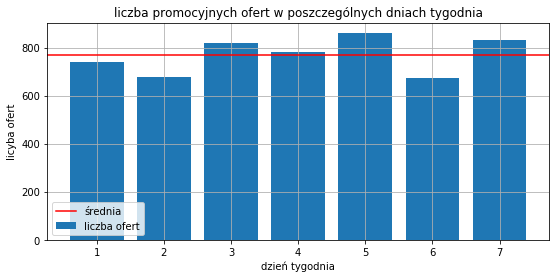

In [21]:
plt.figure(figsize=(9,4))
plt.bar(amount.columns.tolist(), amount.iloc[0].values, label='liczba ofert')
plt.title('liczba promocyjnych ofert w poszczególnych dniach tygodnia')
plt.xlabel('dzień tygodnia')
plt.ylabel('licyba ofert')
plt.axhline(y=amount.iloc[0].values.mean(), color = 'r', linestyle = '-', label='średnia')
plt.legend(loc='lower left')
plt.grid()
plt.show()

<p>
    Liczba promocyjnych ofert w poszczególnych dniach tygodnia nie odstaje zbytnio od średniej.
    </p>

#### Liczba unikalnych produktów promocyjnych w poszczególnych dniach tygodnia

In [22]:
unique_plu = df.plu.unique()

unique_plu_per_day = pd.DataFrame()

for day in df.weekday.unique():
    current = set(df[df.weekday == day].plu.values)
    others = set(df[df.weekday != day].plu.unique())
    unique_qty = len(current - others)
    unique_plu_per_day = unique_plu_per_day.append({'weekday': day, 'offers_qty': len(current), 'unique_products_qty': unique_qty, 'unique_products_percent': round(unique_qty/len(current)*100,2)}, ignore_index=True)

In [23]:
unique_offers_per_day = pd.DataFrame()

for day in df.weekday.unique():
    
    current = df[df.weekday == day][['plu','regular','discount_amount']].to_string(header=False, index=False, index_names=False).split('\n')
    current = set([','.join(ele.split()) for ele in current])
   
    others = df[df.weekday != day][['plu','regular','discount_amount']].to_string(header=False, index=False, index_names=False).split('\n')
    others = set([','.join(ele.split()) for ele in others])
    
    unique_offers_qty = len(current - others)
    
    unique_offers_per_day = unique_offers_per_day.append({'weekday': day, 'unique_offers_qty': unique_offers_qty}, ignore_index=True)

In [24]:
unique = unique_plu_per_day.merge(unique_offers_per_day, on='weekday')
unique['unique_offers_percent'] = round(unique.unique_offers_qty / unique.offers_qty * 100, 2)

unique = unique.set_index('weekday').sort_values(by='weekday')
unique

,offers_qty,unique_products_percent,unique_products_qty,unique_offers_qty,unique_offers_percent
weekday,,,,,
1,738.0,25.20,186.0,250.0,33.88
2,676.0,11.83,80.0,115.0,17.01
3,816.0,11.64,95.0,144.0,17.65
4,780.0,7.05,55.0,76.0,9.74
5,857.0,3.97,34.0,43.0,5.02
6,667.0,0.00,0.0,6.0,0.90
7,832.0,3.37,28.0,41.0,4.93


<p>
Z powyższej tabeli wynika, iż większość produktów w promocjach jest powtarzanych. Oczywiście zgodzę się z twierdzeniem, że im szerszy horyzont czasowy zostałby wzięty pod uwagę, to po pewnym czasie wszystkie produkty byłyby już kiedyś w przeszłości w tej promocji.
</p><p>
Jednakże analizowany okres to jeden tydzień. W sklepie tym znajduje się ponad 30 tysięcy unikalnych produktów (dane z analizy kategorii znajdującej się w tym repozytorium). W analizowanym okresie w promocji występowało 1521 unikalnych produktów i w dodatku można było liczyć na od 0% do 25% - częściej na ok 10% - niepowtarzających się produktów z tych 1521.
</p><p>
Wszystkich jednak zawsze w promocjach najbardziej interesuje cena. Z powyższej tabeli można wywnioskować, że pomimo tego, że produkty powtarzają się w kolejnych dniach tygodnia to cena — czy to w regularna, czy promocyjna — już niekoniecznie. Poniżej wizualizacja w postaci wykresu słupkowego.
    </p><p>W dalszej części postaram się przeanalizować, w jakich zakresach ceny produktów oscylują.
    </p>

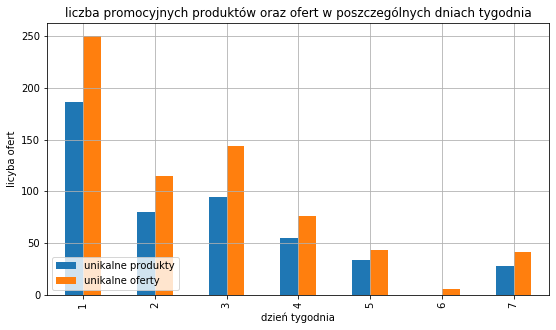

In [25]:
unique[['unique_products_qty','unique_offers_qty']].plot(kind='bar', figsize=(9,5))
# ax = plt.subplot(111)
# ax.bar(unique.index.values, unique.unique_products_qty.values, label='liczba unikalnych produktów')
# ax.bar(unique.index.values, unique.unique_offers_qty.values, label='liczba unikalnych ofert')
plt.title('liczba promocyjnych produktów oraz ofert w poszczególnych dniach tygodnia')
plt.xlabel('dzień tygodnia')
plt.ylabel('licyba ofert')
plt.legend(['unikalne produkty', 'unikalne oferty'], loc='lower left')
plt.grid()
plt.show()

#### 'discount_proc' - procent rabatu

### 4.2 Analiza zmiennych kategorycznych

#### 4.2.1 'availability' - czyli dostępność produktów

In [37]:
availability_general = df.groupby('availability').agg(qty=('plu', 'count'))
availability_general['percent'] = round(availability_general.qty/availability_general.qty.sum() * 100, 2)
availability_general

,qty,percent
availability,,
do koszyka,5364,99.61
obejrzyj w sklepie,21,0.39


<p>
   Produkty promocyjne dzielą się na dwie kategorie, jeśli chodzi o dostępność. Dostępność produktu determinuje, w jaki sposób można do zakupić.
    </p>
    <p>
    Z powyższej tabeli wynika, że większość produktów dostępnych do kupienia w promocji można zarezerwować / kupić przez internet, a po 0.39% produktów należy udać się do sklepu stacjonarnego.
    </p>

#### 4.2.2 'parent_category' - czyli popularność kategorii głównych

##### Ogólny obraz wszystkich kategori głównych

In [145]:
parent_category_by_weekday = df.groupby(['weekday', 'parent_category']).agg(qty=('plu', 'count')).reset_index()
parent_category_by_weekday = parent_category_by_weekday.merge(unique.offers_qty.reset_index(), on='weekday')
parent_category_by_weekday['percent'] = round(parent_category_by_weekday.qty / parent_category_by_weekday.offers_qty * 100, 2)
parent_category_by_weekday.drop('offers_qty', axis=1, inplace=True)

In [146]:
pivot = parent_category_by_weekday.pivot(index='weekday', columns='parent_category', values=['qty', 'percent'])

In [147]:
pivot['percent']

parent_category,agd,agd-do-zabudowy,agd-male,gry-i-konsole,komputery,rtv,telefony-i-nawigacja-gps
weekday,,,,,,,
1,44.04,11.38,14.77,0.54,9.35,16.26,3.79
2,39.05,8.73,19.67,2.81,6.95,17.75,5.62
3,40.44,7.60,16.42,1.96,10.29,16.05,7.60
4,39.36,8.08,17.18,1.67,14.49,16.79,2.56
5,39.44,7.35,14.70,1.87,12.72,16.80,7.47
6,37.03,7.95,18.74,1.65,14.84,19.34,1.35
7,40.50,7.57,17.19,0.96,13.34,13.10,7.45


<p>
    Powyższa tabela prezentuje procentowy udział każdej z kategorii głównych w ofercie promocyjnej w podziale na poszczególne dni tygodnia.
    </p>

In [148]:
pivot['qty']

parent_category,agd,agd-do-zabudowy,agd-male,gry-i-konsole,komputery,rtv,telefony-i-nawigacja-gps
weekday,,,,,,,
1,325.0,84.0,109.0,4.0,69.0,120.0,28.0
2,264.0,59.0,133.0,19.0,47.0,120.0,38.0
3,330.0,62.0,134.0,16.0,84.0,131.0,62.0
4,307.0,63.0,134.0,13.0,113.0,131.0,20.0
5,338.0,63.0,126.0,16.0,109.0,144.0,64.0
6,247.0,53.0,125.0,11.0,99.0,129.0,9.0
7,337.0,63.0,143.0,8.0,111.0,109.0,62.0


<p>Powyższa tabela ilość ofert w każdej z kategorii głównych w ofercie promocyjnej, w podziale na  poszczególne dni tygodnia.</p>

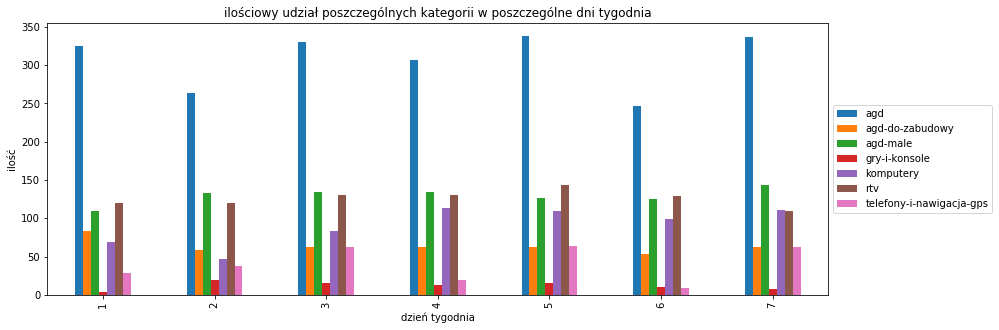

In [152]:
labels = pivot['qty'].columns.tolist()
pivot['qty'].plot(kind='bar', figsize=(14,5))
plt.title('ilościowy udział poszczególnych kategorii w poszczególne dni tygodnia')
plt.xlabel('dzień tygodnia')
plt.ylabel('ilość')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
labels = pivot['qty'].columns.tolist()
pivot['qty'].plot(kind='bar', figsize=(14,5))
plt.title('ilościowy udział poszczególnych kategorii w poszczególne dni tygodnia')
plt.xlabel('dzień tygodnia')
plt.ylabel('ilość')
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()